WORK WITH GPU LOCALLY

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version+
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
__pyTorch VERSION: 1.10.0+cu111
__CUDA VERSION
nvcc fatal   : Unknown option '--version+'
__CUDNN VERSION: 8005
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


**NOTEBOOK**

In [3]:
%matplotlib inline

In [4]:
# Descomenta únicamente si quieres ejecutar este código en Google Colab
from google.colab import drive
import os, sys
drive.mount('/content/drive')
print(os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/TFM/db_isic') #Here put the full path to the folder where you have the files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


Cambio de directorio de trabajo

Importación de librerías

In [5]:
import os
import glob
from tqdm import tqdm
import numpy as np
import copy
import time
import torch
import PIL
import torch.nn.functional as FT
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms, utils
from skimage import io, transform, util
import torchvision.transforms.functional as F
from PIL import Image
import cv2
import csv
import random
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,multilabel_confusion_matrix
from scipy.io import savemat
from sklearn.metrics import roc_auc_score, jaccard_score
from sklearn.preprocessing import LabelBinarizer
from scipy import ndimage
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import pandas as pd
# Set random seed for reproducibility
# manualSeed = 999
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch uses some non-deterministic algorithms
# torch.backends.cudnn.enabled = False

Inicialización de algunos valores

In [6]:
data_dir = 'db_isic'
num_classes_multiclass = 7 
class_names_multiclass=['otras', 'quistes de millium', 'retículo negativo', 'retículo normal', 'streaks', 'glóbulos']

#class_names_multiclass=['background','otras', 'quistes de millium', 'retículo negativo', 'retículo normal', 'streaks', 'glóbulos']
img_size=512           # Size of the images
batchsize_train=16     # Batch size for training
batchsize_test=1       # Batch size for test (it must be one to generate predictions)
epochs = 3500           # Number of epochs to train (must be pair)
step_size=300
result_dir = 'results' # Result directory
# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Base de datos**

In [7]:
trainImageFolder = '/content/drive/My Drive/Colab Notebooks/TFM/db_isic/ISIC-2017_Training_Data'
trainMaskFolder = '/content/drive/My Drive/Colab Notebooks/TFM/db_isic/ISIC-2017_Training_Part2_GroundTruth/gtann'
validImageFolder = '/content/drive/My Drive/Colab Notebooks/TFM/db_isic/ISIC-2017_Validation_Data'
validMaskFolder = '/content/drive/My Drive/Colab Notebooks/TFM/db_isic/ISIC-2017_Validation_Part2_GroundTruth/gtann'
testImageFolder = '/content/drive/My Drive/Colab Notebooks/TFM/db_isic/ISIC-2017_Test_v2_Data'
testMaskFolder = '/content/drive/My Drive/Colab Notebooks/TFM/db_isic/ISIC-2017_Test_v2_Part2_GroundTruth/gtann'

In [8]:
list_train_images = sorted(glob.glob(trainImageFolder+'/ISIC_*.jpg', 
                   recursive = True))
list_train_masks = sorted(glob.glob(trainMaskFolder+'/ISIC_*.mat', 
                   recursive = True))
list_val_images = sorted(glob.glob(validImageFolder+'/ISIC_*.jpg', 
                   recursive = True))
list_val_masks = sorted(glob.glob(validMaskFolder+'/ISIC_*.mat', 
                   recursive = True))
list_test_images = sorted(glob.glob(testImageFolder+'/ISIC_*.jpg', 
                   recursive = True))
list_test_masks = sorted(glob.glob(testMaskFolder+'/ISIC_*.mat', 
                   recursive = True))

Code for asigning the weights for each class

In [ ]:
masks = []
for msk_name in list_train_masks:
    masks.append(loadmat(msk_name)['smgt'])

In [ ]:
classes = np.zeros(7)
for mask in masks:
    for i in range(7):
        classes[i]=classes[i] + np.count_nonzero(mask == i)
print(classes)

In [ ]:
weights_classes = 1.76307639e+09/classes
print(weights_classes)

In [ ]:
weights_classes

In [ ]:
weights_classes=np.array([1.53294988e-01, 9.99999998e-01, 3.37177737e+01, 6.56752404e+01,
 3.53675758e+00, 1.97509648e+02, 3.78874615e+01]
)

In [ ]:
weights_classes=np.array([1.53294988e-01, 1, 1.5e+01, 3.25e+01,
 3.5e+00, 0.5e+02, 1.9e+01]
)

In [ ]:
classes = np.zeros(6)
for mask in masks:
      for i in range(6):
    classes[i]=classes[i] + np.count_nonzero(mask == i+1)
print(classes)

In [ ]:
weights_classes = 23602424/classes
print(weights_classes)

# **Dataloader**

In [ ]:
def is_grayscale_image(image):
    return (len(image.shape) == 2) or (len(image.shape) == 3 and image.shape[-1] == 1)

def fancy_pca(img, alpha=0.1):
    """Perform 'Fancy PCA' augmentation from:
    http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
    Args:
        img:  numpy array with (h, w, rgb) shape, as ints between 0-255)
        alpha:  how much to perturb/scale the eigen vecs and vals
                the paper used std=0.1
    Returns:
        numpy image-like array as float range(0, 1)
    """
    if is_grayscale_image(img) or img.dtype != np.uint8:
        raise TypeError("Image must be RGB image in uint8 format.")

    orig_img = img.astype(float).copy()

    img = img / 255.0  # rescale to 0 to 1 range

    # flatten image to columns of RGB
    img_rs = img.reshape(-1, 3)
    # img_rs shape (640000, 3)

    # center mean
    img_centered = img_rs - np.mean(img_rs, axis=0)

    # paper says 3x3 covariance matrix
    img_cov = np.cov(img_centered, rowvar=False)

    # eigen values and eigen vectors
    eig_vals, eig_vecs = np.linalg.eigh(img_cov)

    # sort values and vector
    sort_perm = eig_vals[::-1].argsort()
    eig_vals[::-1].sort()
    eig_vecs = eig_vecs[:, sort_perm]

    # get [p1, p2, p3]
    m1 = np.column_stack((eig_vecs))

    # get 3x1 matrix of eigen values multiplied by random variable draw from normal
    # distribution with mean of 0 and standard deviation of 0.1
    m2 = np.zeros((3, 1))
    # according to the paper alpha should only be draw once per augmentation (not once per channel)
    # alpha = np.random.normal(0, alpha_std)

    # broad cast to speed things up
    m2[:, 0] = alpha * eig_vals[:]

    # this is the vector that we're going to add to each pixel in a moment
    add_vect = np.matrix(m1) * np.matrix(m2)

    for idx in range(3):  # RGB
        orig_img[..., idx] += add_vect[idx] * 255

    # for image processing it was found that working with float 0.0 to 1.0
    # was easier than integers between 0-255
    # orig_img /= 255.0
    orig_img = np.clip(orig_img, 0.0, 255.0)

    # orig_img *= 255
    orig_img = orig_img.astype(np.uint8)

    return orig_img


In [ ]:
class RigaDataset(Dataset):
    """Binary Segmentation Dataset"""

    def __init__(self, root_dir, list_train_images, list_train_masks, list_val_images, list_val_masks,  trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=True, use_only_train=[], transform=None, subset=None,  imagecolormode='rgb', maskcolormode='grayscale'):
        """
        Args:
            root_dir (string): Directory with all the images and should have the following structure.
            root
            --Images
            # -----Img 
            -----Img N
            --Mask
            -----Mask 1
            -----Mask N
            imageFolder (string) = 'Images' : Name of the folder which contains the Images.
            maskFolder (string)  = 'Masks : Name of the folder which contains the Masks.
            transform (callable, optional): Optional transform to be applied on a sample.
            subset: 'Train', 'Val' or 'Test' to select the appropriate set.
            imagecolormode: 'rgb' or 'grayscale'
            maskcolormode: 'rgb' or 'grayscale'
        """
        self.color_dict = {'rgb': 1, 'grayscale': 0}
        self.imagecolorflag = self.color_dict[imagecolormode]
        self.maskcolorflag = self.color_dict[maskcolormode]
        self.root_dir = root_dir
        self.transform = transform
        self.binary=binary
        assert(subset in ['Train', 'Val', 'Test'])
        if (subset=='Train'):
            self.image_names = list_train_images
            self.mask_names = list_train_masks

        elif(subset=='Val'):
            self.image_names = list_val_images
            self.mask_names = list_val_masks

        else:

            self.image_names = list_test_images
            self.mask_names = list_test_masks

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        msk_name = self.mask_names[idx]

        if self.maskcolorflag:

            mask = loadmat(msk_name)['smgt']
        else:

            mask = loadmat(msk_name)['smgt']
            if (self.binary):
                # In a binary dataset, the masks are usually given in uint8 form: 0-background, 255 foreground
                # For the BCELoss, we need the background mask (inverse of the foreground one)
                mask2 = 255-mask
                # We concatenate both
                mask = np.concatenate((mask2[np.newaxis,:,:],mask[np.newaxis,:,:]),axis=0)

        image = cv2.imread(img_name, self.imagecolorflag).transpose(2,0,1)
        
        sample = {'image': image, 'mask': mask, 'img_path': img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample

class FancyPCA(object):
    """modify colour of the image"""
    def __init__(self, max_alpha):
        self.max_alpha = max_alpha*10

    def __call__(self, sample):
        rand_alph = random.randrange(-self.max_alpha, self.max_alpha, 1)*0.1
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']
        image = image.transpose(1, 2, 0)
        image = fancy_pca(image, alpha=rand_alph)
        image=image.transpose(2, 0, 1)
        return {'image': image, 'mask': mask, 'img_path' : img_path}

    
class ColorJitter(object):
    """modify brigtness, contrast and saturation of the image"""
    def __init__(self, bri,cont,sat,hue):
        self.CJ=transforms.ColorJitter(brightness=bri, contrast=cont, saturation=sat, hue=hue)

    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']
        image = image.transpose(1, 2, 0)
        pil_image=Image.fromarray(util.img_as_ubyte(image))
        pil_image=self.CJ(pil_image)
#         image=util.img_as_float(np.asarray(pil_image))
        image=np.asarray(pil_image)
        image=image.transpose(2,0,1)
        return {'image': image, 'mask': mask, 'img_path' : img_path}
    

class RandomHorizontalFlip(object):
    """Flip horizontally."""
    def __init__(self):
        pass
    def __call__(self, sample):
        k = random.randint(0, 1)
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']
        if k:
            image = image.transpose(1, 2, 0)
            image = np.flip(image, 1)
            image = image.transpose(2,0,1)
            mask = np.flip(mask, 1)
        return {'image': image, 'mask': mask, 'img_path' : img_path}


    
class RandomRotation(object):
    """ Rotate the image randomly"""
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, sample):
        rand_i = np.random.randint(-self.angle, self.angle)
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']
        image = image.transpose(1, 2, 0)
        image = ndimage.rotate(image, rand_i, reshape=False)

        mask = ndimage.rotate(mask, rand_i, reshape=False,order=0)
        image = image.transpose(2,0,1)
        return {'image': image, 'mask': mask, 'img_path' : img_path}
    

class CropByMask(object):
    """Crop the image using the lesion mask.

    Args:
        border (tuple or int): Border surrounding the mask. We dilate the mask as the skin surrounding 
        the lesion is important for dermatologists.
        If it is a tuple, then it is (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border
            
    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'], sample['img_path']
        image = image.transpose(1, 2, 0)
   
        h, w = image.shape[:2]
        #Calculamos los índices del bounding box para hacer el cropping
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Recortamos la imagen
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        image=image.transpose(2,0,1)


        return {'image': image, 'mask': mask, 'img_path' : img_path}
    
class Rescale(object):
    """Re-scale image to a predefined size.

    Args:
        output_size (tuple or int): The desired size. If it is a tuple, output is the output_size. 
        If it is an int, the smallest dimension will be the output_size
            a we will keep fixed the original aspect ratio.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']

        image = image.transpose(1, 2, 0)

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        msk = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        img=img.transpose(2, 0, 1)
        # img = transform.resize(image, (new_h, new_w))
        # msk = transform.resize(mask, (new_h, new_w))

        return {'image': img, 'mask': msk, 'img_path' : img_path}

class RandomCrop(object):
    """Randomly crop the image.

    Args:
        output_size (tuple or int): Crop size. If  int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']

        image = image.transpose(1, 2, 0)

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        if h>new_h:
            top = np.random.randint(0, h - new_h)
        else:
            top=0
            
        if w>new_w: 
            left = np.random.randint(0, w - new_w)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]
        image=image.transpose(2, 0, 1)

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask, 'img_path': img_path}
    
class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'],sample['img_path']
        image = image.transpose(1, 2, 0)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w
        
        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0
            
        if w>new_w: 
            left = int(rem_w/2)
        else:
            left = 0
            
        image = image[top: top + new_h,
                     left: left + new_w]
        
        image=image.transpose(2, 0, 1)

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'mask': mask, 'img_path': img_path}

# Define few transformations for the Segmentation Dataloader
class Augm(object):
    """Perform data augmentation. NOT IMPLEMENTED YET."""
    def __init__(self, data_augm):
        self.data_augm = data_augm
    def __call__(self, sample):
        img, mask, img_path = sample['image'], sample['mask'], sample['img_path']
        if (self.data_augm):
            # DATA AUGMENTATION: IMPLEMENT YOUR VERSION
            pass
        else:
            pass
        
        return {'image': img,
                'mask': mask, 
                'img_path': img_path}

class Resize(object):
    """Resize image and/or masks."""

    def __init__(self, imageresize, maskresize):
        self.imageresize = imageresize
        self.maskresize = maskresize

    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'], sample['img_path']
        if len(image.shape) == 3:
            image = image.transpose(1, 2, 0)
        if len(mask.shape) == 3:
            mask = mask.transpose(1, 2, 0)
        mask = cv2.resize(mask, self.maskresize, interpolation=cv2.INTER_NEAREST)
        image = cv2.resize(image, self.imageresize, interpolation=cv2.INTER_AREA)
        if len(image.shape) == 3:
            image = image.transpose(2, 0, 1)
        if len(mask.shape) == 3:
            mask = mask.transpose(2, 0, 1)

        return {'image': image,
                'mask': mask,
                'img_path': img_path}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, maskresize=None, imageresize=None):
        image, mask, img_path = sample['image'], sample['mask'], sample['img_path']
        if len(image.shape) == 2:
            image = image.reshape((1,)+image.shape)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask), 
                'img_path': img_path}


class NormalizeBinary(object):
    '''Normalize image'''
    def __init__(self, image_mean,image_std):
        self.image_mean = image_std
        self.image_std = image_std
    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'], sample['img_path']
        # Binary segmentation: masks can be float with 0-1 values
        if (self.image_mean is None):
            return {'image': image.type(torch.FloatTensor)/255,
                    'mask': mask.type(torch.FloatTensor)/255, 
                    'img_path': img_path}
        else:   
            return {'image': F.normalize(image.type(torch.FloatTensor)/255,self.image_mean,self.image_std),
                    'mask': mask.type(torch.FloatTensor)/255, 
                    'img_path': img_path}

        
class NormalizeMulticlass(object):
    '''Normalize image'''
    def __init__(self, image_mean,image_std):
        self.image_mean = image_std
        self.image_std = image_std
    def __call__(self, sample):
        image, mask, img_path = sample['image'], sample['mask'], sample['img_path']
        if (self.image_mean is None):
            # Masks must be LongTensor with 0-1-2... indicators for the classes
            return {'image': image.type(torch.FloatTensor)/255,
                    'mask': mask.type(torch.LongTensor), 
                    'img_path': img_path}
        else:   
            return {'image': F.normalize(image.type(torch.FloatTensor)/255,self.image_mean,self.image_std),
                    'mask': mask.type(torch.LongTensor), 
                    'img_path': img_path}

def get_dataloader_riga(data_dir, list_train_images, list_train_masks, list_val_images, list_val_masks,trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=True, use_only_train=[], batch_size=4, img_size=256, img_size2=128, img_size_x=512,img_size_y=716, data_augm=False, image_mean=None,image_std=None):
    """
        Create training, validation and testing dataloaders from a single folder.
    """
    if (binary):
        data_transforms = {
            #'Train': transforms.Compose([Augm(data_augm), Resize((img_size,img_size),(img_size,img_size)), ToTensor(), NormalizeBinary(image_mean,image_std)]),
            #'Val': transforms.Compose([Resize((img_size,img_size),(img_size,img_size)), ToTensor(), NormalizeBinary(image_mean,image_std)]),
            #'Test': transforms.Compose([Resize((img_size,img_size),(img_size,img_size)), ToTensor(), NormalizeBinary(image_mean,image_std)]),
            'Train': transforms.Compose([Resize((img_size_y,img_size_x),(img_size_y,img_size_x)), ToTensor(), NormalizeBinary(image_mean,image_std)]),
            'Val': transforms.Compose([Resize((img_size_y,img_size_x),(img_size_y,img_size_x)), ToTensor(), NormalizeBinary(image_mean,image_std)]),
            'Test': transforms.Compose([Resize((img_size_y,img_size_x),(img_size_y,img_size_x)), ToTensor(), NormalizeBinary(image_mean,image_std)]),
            #'Train': transforms.Compose([ ToTensor(), NormalizeBinary(image_mean,image_std)]),
            #'Val': transforms.Compose([ToTensor(), NormalizeBinary(image_mean,image_std)]),
            #'Test': transforms.Compose([ToTensor(), NormalizeBinary(image_mean,image_std)]),
            }
        image_datasets = {x: RigaDataset(data_dir, list_train_images, list_train_masks, list_val_images, list_val_masks, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=binary, use_only_train=use_only_train, subset=x, transform=data_transforms[x])
                          for x in ['Train', 'Val', 'Test']}
        
    else:
        data_transforms = {


#             'Train': transforms.Compose([RandomRotation(180),ColorJitter(0.15,0.15,0.1,0),FancyPCA(1.5),RandomHorizontalFlip(),CropByMask(0),Rescale(img_size),RandomCrop(img_size), ToTensor(), NormalizeMulticlass(image_mean,image_std)]),             
            'Train': transforms.Compose([ColorJitter(0.1,0.1,0.1,0),FancyPCA(1.5),RandomRotation(180),RandomHorizontalFlip(),CropByMask(0),Rescale(img_size),RandomCrop(img_size2), ToTensor(), NormalizeMulticlass(image_mean,image_std)]),
            'Val': transforms.Compose([CropByMask(0),Rescale(img_size),CenterCrop(img_size), ToTensor(), NormalizeMulticlass(image_mean,image_std)]),
            'Test': transforms.Compose([CropByMask(0),Rescale(img_size),RandomCrop(img_size),ToTensor(), NormalizeMulticlass(image_mean,image_std)]),

            }
        image_datasets = {x: RigaDataset(data_dir, list_train_images, list_train_masks, list_val_images, list_val_masks,trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=binary, use_only_train=use_only_train, subset=x, transform=data_transforms[x])
                          for x in ['Train', 'Val', 'Test']}

    dataloaders = {'Train': DataLoader(image_datasets['Train'], batch_size=batch_size,
                                 shuffle=True, num_workers=2),
                   'Val': DataLoader(image_datasets['Val'], batch_size=batch_size,
                                 shuffle=False, num_workers=2),
                   'Test': DataLoader(image_datasets['Test'], batch_size=batch_size,
                                 shuffle=False, num_workers=2)}
    return dataloaders


In [ ]:
# Use the generic mean if it is not given
if (not os.path.exists(os.path.join(data_dir,'mean-channel.npy'))):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
else:
    mean=np.load(os.path.join(data_dir,'mean-channel.npy'))
    std=np.load(os.path.join(data_dir,'std-channel.npy'))
use_only_train=[] # if we want to use all images
dataloaders = get_dataloader_riga(
    #data_dir, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=False, use_only_train=use_only_train, batch_size=4, data_augm=False, image_mean=mean,image_std=std)
    data_dir,  list_train_images, list_train_masks, list_val_images, list_val_masks, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=False, use_only_train=use_only_train, batch_size=batchsize_train, img_size=256, img_size2=128, img_size_x=512,img_size_y=716, data_augm=False)

Visualize dataset

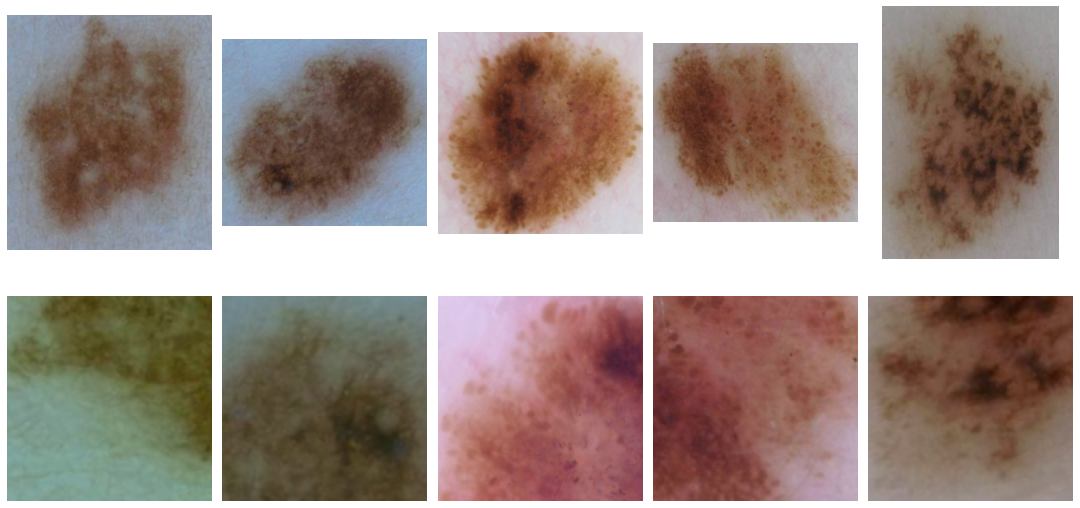

In [ ]:
cj = ColorJitter(0.15,0.15,0.1,0)
fpca = FancyPCA(1.5)
rr = RandomRotation(180)
rhf = RandomHorizontalFlip()
cbm = CropByMask(0)
rsc = Rescale(256)
rc = RandomCrop(128)
i=0
permute_2 = [2, 1, 0]

fig = plt.figure()
fig.set_size_inches(18.5, 9)

for im, msk in zip(list_train_images[5:10],list_train_masks[5:10]):
  image = cv2.imread(im, 1)
  mask = loadmat(msk)['smgt']
  sample = {'image': image.transpose(2, 0, 1), 'mask': mask, 'img_path': im}
  sam = cj(sample)
  sam = fpca(sam)
  sam = rr(sam)
  sam = rhf(sam)
  sam = cbm(sam)
  sam = rsc(sam)
  sam = rc(sam)
  i=i+1
  tr_image=sam['image'].transpose(1, 2, 0)
  tr_image =  tr_image[ :, :, permute_2]
  image = image[ :, :, permute_2]

  sam1 = cbm(sample)
  sam1 = rsc(sam1)

  image1=sam1['image'].transpose(1, 2, 0)
  image1 =  image1[ :, :, permute_2]


  ax = plt.subplot(2, 5, i)
  # plt.tight_layout()
  # ax.set_title(type(tsfrm).__name__)
  plt.imshow(image1)
  plt.axis('off')
  ax = plt.subplot(2, 5, 5+i)
  # plt.tight_layout()
  # ax.set_title(type(tsfrm).__name__)
  plt.imshow(tr_image)
  plt.axis('off')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.05)
plt.show()
 

In [ ]:
def get_deeplabv3(num_classes=1):
    model = deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, num_classes)
    return model

**Training and testing functions**

In [ ]:
# We set the batchnorm modules to eval
def set_bn_eval(mm):
    if isinstance(mm, torch.nn.modules.batchnorm._BatchNorm):
        mm.eval()
        
def train_model(model, criterion, dataloaders, device, optimizer, lr_scheduler, metrics, bpath, model_name, num_classes=2, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_jaccard = 0

    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Val_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Val_{m}' for m in metrics.keys()]
#     with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
#         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#         writer.writeheader()
    with open(os.path.join(bpath, 'log2.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        if os.path.exists(os.path.join(bpath,model_name+'-epoch{}.pth'.format(epoch))):
            print("=> loading checkpoint '{}'".format(epoch))
            checkpoint = torch.load(os.path.join(bpath,model_name+'-epoch{}.pth'.format(epoch)))
            lr_scheduler.load_state_dict(checkpoint['scheduler'])
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            best_jaccard=checkpoint['best_jaccard']
            print("=> loaded checkpoint '{}'" .format(epoch))
        else:
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-' * 10)
            # Each epoch has a training and validation phase
            # Initialize batch summary
#             batchsummary = {a: [0] for a in fieldnames}
            batchsummary2 = {a: [0] for a in fieldnames}

            for phase in ['Train', 'Val']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                model.apply(set_bn_eval)

                # Iterate over data.
                for sample in tqdm(iter(dataloaders[phase])):
                    inputs = sample['image'].to(device)
                    masks = sample['mask'].to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        loss = criterion(outputs['out'], masks)
                        
                        y_pred = outputs['out']#.data.cpu().numpy().ravel()
                        y_prob = torch.nn.functional.softmax(y_pred, dim=1)
                        _,y_pred2 = torch.max(y_prob,dim=1)
                        y_pred = y_pred2.data.cpu().numpy().ravel()
                        y_prob = np.reshape(np.transpose(y_prob.data.cpu().numpy(),(1,0,2,3)),(num_classes,y_pred.shape[0]))
                        y_true = masks.data.cpu().numpy()#.ravel()
                        if (num_classes==2):
                            y_true = y_true>0
                        lb = LabelBinarizer()
                        lb.fit([f for f in range(0,num_classes)])
                        for name, metric in metrics.items():
                            if name == 'jaccard_score':
                                if (num_classes==2):
#                                     ji=metric(y_true[:,1,:,:].reshape(-1,1), y_pred, average=None)
                                    ji2=metric(y_true[:,1,:,:][np.nonzero(y_true[:,1,:,:])].reshape(-1,1), y_pred[np.nonzero(y_true[:,1,:,:])], average=None)
                                else:
                                    # ji=metric(y_true.reshape(-1,1), y_pred, labels=np.unique(y_pred),average=None)
                                    #ji=metric(y_true.reshape(-1,1), y_pred, labels=np.unique(y_true),average=None)
                                    # ji2=metric(y_true[np.nonzero(y_true)].reshape(-1,1), y_pred[np.nonzero(y_true)], labels=np.unique(y_true),average=None)
#                                     ji=metric(y_true.reshape(-1,1), y_pred2.cpu().numpy().reshape(-1,1), average=None)

                                    #ji2=metric(y_true.reshape(-1,1), y_pred2.cpu().numpy().reshape(-1,1), average=None)
                                    ji2=metric(y_true[np.nonzero(y_true)].reshape(-1,1), y_pred2.cpu().numpy()[np.nonzero(y_true)].reshape(-1,1),average=None)


#                                 batchsummary[f'{phase}_{name}'].append(
#                                     np.mean(ji[1:]))
                                batchsummary2[f'{phase}_{name}'].append(
                                    np.mean(ji2))
                            else:
                                if (num_classes==2):
                                    batchsummary2[f'{phase}_{name}'].append(
                                        metric(y_true[:,1,:,:].reshape(-1,1), y_prob[1:,:].T, average='micro',multi_class='ovr'))
                                else:
#                                     batchsummary[f'{phase}_{name}'].append(
#                                         metric(lb.transform(y_true.reshape(-1,1)), y_prob.T, average='micro',multi_class='ovr'))
                                    batchsummary2[f'{phase}_{name}'].append(
                                        metric(lb.transform(y_true.reshape(-1,1)), y_prob.T, average='micro',multi_class='ovr'))
                                        
                                        #metric(lb.transform(y_true[np.nonzero(y_true)].reshape(-1,1)), y_prob[np.nonzero(y_true)].T, average='micro',multi_class='ovr'))

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()
#                 batchsummary['epoch'] = epoch
                batchsummary2['epoch'] = epoch
                epoch_loss = loss
#                 batchsummary[f'{phase}_loss'] = epoch_loss.item()
                batchsummary2[f'{phase}_loss'] = epoch_loss.item()
                print('{} Loss: {:.4f}'.format(
                    phase, loss))
            for field in fieldnames[3:]:
#                 batchsummary[field] = np.mean(batchsummary[field][1:])
                batchsummary2[field] = np.mean(batchsummary2[field][1:])
#             print(batchsummary)
            print(batchsummary2)
            with open(os.path.join(bpath, 'log2.csv'), 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow(batchsummary2)
                # deep copy the model if the jaccard is the best
                if phase == 'Val' and batchsummary2['Val_jaccard_score'] > best_jaccard:
#                if phase == 'Val' and batchsummary['Train_jaccard_score'] > best_jaccard:
                    best_jaccard = batchsummary2['Val_jaccard_score']
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'state_dict':best_model_wts}, os.path.join(bpath, model_name+'_best.pth.tar'))
#             with open(os.path.join(bpath, 'log2.csv'), 'a', newline='') as csvfile:
#                 writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#                 writer.writerow(batchsummary2)
                # deep copy the model if the jaccard is the best
            #    if phase == 'Val' and batchsummary2['Val_jaccard_score'] > best_jaccard2:
            #        best_jaccard2 = batchsummary2['Val_jaccard_score']
            #        best_model_wts = copy.deepcopy(model.state_dict())
            #        torch.save({'state_dict':best_model_wts}, os.path.join(bpath, model_name+'_best2.pth.tar'))

            lr_scheduler.step()
            # Save the state  
            state = {'epoch': epoch, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'scheduler':lr_scheduler.state_dict(), 
                      'best_jaccard': best_jaccard, }
#             torch.save(state, os.path.join(bpath, model_name+'-epoch{}.pth'.format(epoch)))
            torch.save(state, os.path.join(bpath, model_name+'-last_epoch.pth'))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Highest Jaccard: {:4f}'.format(best_jaccard))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### TRAIN_IGNOREINDEX1

In [ ]:
# We set the batchnorm modules to eval
def set_bn_eval(mm):
    if isinstance(mm, torch.nn.modules.batchnorm._BatchNorm):
        mm.eval()
        
def train_model(model, criterion, dataloaders, device, optimizer, lr_scheduler, metrics, bpath, model_name, num_classes=2, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_jaccard = 0

    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Val_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Val_{m}' for m in metrics.keys()]
#     with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
#         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#         writer.writeheader()
    with open(os.path.join(bpath, 'log2.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs+1):
        if os.path.exists(os.path.join(bpath,model_name+'-epoch{}.pth'.format(epoch))):
            print("=> loading checkpoint '{}'".format(epoch))
            checkpoint = torch.load(os.path.join(bpath,model_name+'-epoch{}.pth'.format(epoch)))
            lr_scheduler.load_state_dict(checkpoint['scheduler'])
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            best_jaccard=checkpoint['best_jaccard']
            print("=> loaded checkpoint '{}'" .format(epoch))
        else:
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-' * 10)
            # Each epoch has a training and validation phase
            # Initialize batch summary
#             batchsummary = {a: [0] for a in fieldnames}
            batchsummary2 = {a: [0] for a in fieldnames}

            for phase in ['Train', 'Val']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                model.apply(set_bn_eval)

                # Iterate over data.
                for sample in tqdm(iter(dataloaders[phase])):
                    inputs = sample['image'].to(device)
                    masks = sample['mask'].to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        loss = criterion(outputs['out'], masks)
                        
                        y_pred = outputs['out']#.data.cpu().numpy().ravel()
                        y_prob = torch.nn.functional.softmax(y_pred, dim=1)
                        _,y_pred2 = torch.max(y_prob,dim=1)
                        y_pred = y_pred2.data.cpu().numpy().ravel()
                        y_prob = np.reshape(np.transpose(y_prob.data.cpu().numpy(),(1,0,2,3)),(num_classes,y_pred.shape[0]))
                        y_true = masks.data.cpu().numpy()#.ravel()
                        y_true2 = y_true
                        y_true2[y_true==1]=0
                        if (num_classes==2):
                            y_true = y_true>0
                        lb = LabelBinarizer()
                        lb.fit([f for f in range(0,num_classes)])
                        for name, metric in metrics.items():
                            if name == 'jaccard_score':
                                if (num_classes==2):
#                                     ji=metric(y_true[:,1,:,:].reshape(-1,1), y_pred, average=None)
                                    ji2=metric(y_true2[:,1,:,:][np.nonzero(y_true2[:,1,:,:])].reshape(-1,1), y_pred[np.nonzero(y_true2[:,1,:,:])], average=None)
                                else:
                                    # ji=metric(y_true.reshape(-1,1), y_pred, labels=np.unique(y_pred),average=None)
                                    #ji=metric(y_true.reshape(-1,1), y_pred, labels=np.unique(y_true),average=None)
                                    # ji2=metric(y_true[np.nonzero(y_true)].reshape(-1,1), y_pred[np.nonzero(y_true)], labels=np.unique(y_true),average=None)
#                                     ji=metric(y_true.reshape(-1,1), y_pred2.cpu().numpy().reshape(-1,1), average=None)

                                    #ji2=metric(y_true.reshape(-1,1), y_pred2.cpu().numpy().reshape(-1,1), average=None)
                                    ji2=metric(y_true2[np.nonzero(y_true2)].reshape(-1,1), y_pred2.cpu().numpy()[np.nonzero(y_true2)].reshape(-1,1),average=None)


#                                 batchsummary[f'{phase}_{name}'].append(
#                                     np.mean(ji[1:]))
                                batchsummary2[f'{phase}_{name}'].append(
                                    np.mean(ji2))
                            else:
                                if (num_classes==2):
                                    batchsummary2[f'{phase}_{name}'].append(
                                        metric(y_true[:,1,:,:].reshape(-1,1), y_prob[1:,:].T, average='micro',multi_class='ovr'))
                                else:
#                                     batchsummary[f'{phase}_{name}'].append(
#                                         metric(lb.transform(y_true.reshape(-1,1)), y_prob.T, average='micro',multi_class='ovr'))
                                    batchsummary2[f'{phase}_{name}'].append(
                                        metric(lb.transform(y_true.reshape(-1,1)), y_prob.T, average='micro',multi_class='ovr'))
                                        
                                        #metric(lb.transform(y_true[np.nonzero(y_true)].reshape(-1,1)), y_prob[np.nonzero(y_true)].T, average='micro',multi_class='ovr'))

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()
#                 batchsummary['epoch'] = epoch
                batchsummary2['epoch'] = epoch
                epoch_loss = loss
#                 batchsummary[f'{phase}_loss'] = epoch_loss.item()
                batchsummary2[f'{phase}_loss'] = epoch_loss.item()
                print('{} Loss: {:.4f}'.format(
                    phase, loss))
            for field in fieldnames[3:]:
#                 batchsummary[field] = np.mean(batchsummary[field][1:])
                batchsummary2[field] = np.mean(batchsummary2[field][1:])
#             print(batchsummary)
            print(batchsummary2)
            with open(os.path.join(bpath, 'log2.csv'), 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow(batchsummary2)
                # deep copy the model if the jaccard is the best
                if phase == 'Val' and batchsummary2['Val_jaccard_score'] > best_jaccard:
#                if phase == 'Val' and batchsummary['Train_jaccard_score'] > best_jaccard:
                    best_jaccard = batchsummary2['Val_jaccard_score']
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({'state_dict':best_model_wts}, os.path.join(bpath, model_name+'_best.pth.tar'))
#             with open(os.path.join(bpath, 'log2.csv'), 'a', newline='') as csvfile:
#                 writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#                 writer.writerow(batchsummary2)
                # deep copy the model if the jaccard is the best
            #    if phase == 'Val' and batchsummary2['Val_jaccard_score'] > best_jaccard2:
            #        best_jaccard2 = batchsummary2['Val_jaccard_score']
            #        best_model_wts = copy.deepcopy(model.state_dict())
            #        torch.save({'state_dict':best_model_wts}, os.path.join(bpath, model_name+'_best2.pth.tar'))

            lr_scheduler.step()
            # Save the state  
            state = {'epoch': epoch, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(),
                      'scheduler':lr_scheduler.state_dict(), 
                      'best_jaccard': best_jaccard, }
#             torch.save(state, os.path.join(bpath, model_name+'-epoch{}.pth'.format(epoch)))
            torch.save(state, os.path.join(bpath, model_name+'-last_epoch.pth'))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Highest Jaccard: {:4f}'.format(best_jaccard))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model2 = get_deeplabv3(num_classes=num_classes_multiclass)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model2

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight,1.0)
        

### **Train**

In [ ]:
import torch.nn as nn
tic = time.time() 
manualSeed = 999
model = get_deeplabv3(num_classes=num_classes_multiclass)
# model.backbone.conv1.stride = (1,1)
# model.classifier[0].convs[1][0] = nn.Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
# model.classifier[0].convs[2][0] = nn.Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
# model.classifier[0].convs[3][0] = nn.Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)

# Use gpu if available
model.to(device)
# result_dir = 'FULL_bs16_sc128_SIweights_5e-4_5e-6_2workers'
result_dir= 'result_dir'
model_name='DLV3_INIT'

# Multi-class database
#dataloaders = get_dataloader_riga(
#    data_dir, maskFolder='masks_full', binary=False, use_only_train=use_only_train, batch_size=batchsize_train, img_size=img_size, data_augm=False, image_mean=mean,image_std=std)

# Training stage
model.train()

# Create the experiment directory if not present
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

# Specify the loss function
class_weights = torch.FloatTensor(weights_classes).cuda()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean',ignore_index=0)# 7 classes


# Specify the optimizer with a lower learning rate for backbone
params_classifier = [p for p in model.classifier.parameters() if p.requires_grad]

params_backbone = [p for p in model.backbone.parameters() if p.requires_grad]

# Initialize the classifier-conv_layer weights, to adapt to the new paradigm (retinography vs natural images)
#torch.manual_seed(manualSeed)
model.classifier.apply(weights_init)

# We apply a different lr to backbone and classifier parts
optimizer = torch.optim.Adam([
{'params': params_backbone},
{'params': params_classifier, 'lr': 1e-3}
], lr=1e-5, weight_decay=0)

# optimizer = torch.optim.SGD([
# {'params': params_backbone},
# {'params': params_classifier, 'lr': 0.5e-2}
# ], lr=0.5e-4,weight_decay=0)
step_size = 120
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                          step_size=step_size,
                                          gamma=0.9)


# Specify the evaluation metrics
metrics = {'jaccard_score': jaccard_score}

trained_model = train_model(model, criterion, dataloaders, device, optimizer, lr_scheduler, metrics=metrics, bpath=result_dir, model_name=model_name, num_classes=num_classes_multiclass, num_epochs=epochs)
toc = time.time()
print('Elapsed time:')
print(toc-tic)
print(' ------- ')
print('Time init')
print(tic)
print(' ------- ')
print('Time end')
print(toc)

# **Retrain**

In [ ]:
use_only_train=[]
import torch.nn as nn
result_dir = 'result_dir'
result_dir_2 = 'result_dir_2'
model_name='DLV3_INIT'
weights2=torch.load(os.path.join(result_dir,model_name+'-last_epoch.pth'),map_location='cpu')['state_dict']
#weights2=torch.load(os.path.join(result_dir,model_name+'_best.pth.tar'),map_location='cpu')['state_dict']

model_3 = get_deeplabv3(num_classes_multiclass)
# model_3.classifier[0].convs[1][0]=nn.Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
# model_3.classifier[0].convs[2][0]=nn.Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
# model_3.classifier[0].convs[3][0]=nn.Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)

model_3.load_state_dict(weights2)
model_3.to(device)
# Training stage.

model_3.train()

#result_dir = 'results'
# Create the experiment directory if not present
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

# Specify the loss function
class_weights = torch.FloatTensor(weights_classes).cuda()
criterion = torch.nn.CrossEntropyLoss(weight=class_weights,reduction='mean',ignore_index=0)# 3 classes

# Specify the optimizer with a lower learning rate for backbone
params_classifier = [p for p in model_3.classifier.parameters() if p.requires_grad]

params_backbone = [p for p in model_3.backbone.parameters() if p.requires_grad]

# Initialize the classifier-conv_layer weights, to adapt to the new paradigm 
manualSeed = 999
#torch.manual_seed(manualSeed)
#model.classifier.apply(weights_init)

# We apply a different lr to backbone and classifier parts
optimizer = torch.optim.Adam([
{'params': params_backbone},
{'params': params_classifier, 'lr': 1e-4}
], lr=1e-6,weight_decay=0)
step_size = 3000
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                          step_size=step_size,
                                          gamma=0.9)

epochs = 2500
# Specify the evaluation metrics
metrics = {'jaccard_score': jaccard_score, 'auroc': roc_auc_score}
trained_model = train_model(model_3, criterion, dataloaders, device,
                        optimizer, lr_scheduler, bpath=result_dir_2, model_name=model_name,
                        metrics=metrics, num_classes=num_classes_multiclass, num_epochs=epochs)

Epoch 1/2500
----------


  0%|          | 0/125 [00:00<?, ?it/s]/home/maria/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 125/125 [46:37<00:00, 22.38s/it]

Train Loss: 0.5340



100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


Val Loss: 2.1801
{'epoch': 1, 'Train_loss': 0.5340063571929932, 'Val_loss': 2.180079698562622, 'Train_jaccard_score': 0.4358210208149789, 'Train_auroc': 0.2983451986926181, 'Val_jaccard_score': 0.3892862768137661, 'Val_auroc': 0.23309428427906836}
Epoch 2/2500
----------


100%|██████████| 125/125 [46:38<00:00, 22.38s/it]

Train Loss: 0.3472



100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


Val Loss: 1.5864
{'epoch': 2, 'Train_loss': 0.34716013073921204, 'Val_loss': 1.586387038230896, 'Train_jaccard_score': 0.44391489358960373, 'Train_auroc': 0.2998318744878634, 'Val_jaccard_score': 0.37458781727409096, 'Val_auroc': 0.23252983059782797}
Epoch 3/2500
----------


 98%|█████████▊| 122/125 [45:42<00:58, 19.35s/it]

# **Test**

In [ ]:
def test_segmentation_model_multiclass_3(model, num_classes, class_names, result_dir, SAVE_OPT, labels,img_size_x,img_size_y, list_images, list_masks, batch_size=1):
    cm_total=np.zeros((len(class_names),len(class_names))) #confusion matrix initialization
    cm_multi_total=np.array([[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]]])
    cbm = CropByMask(0)
    rscl = Rescale(256)
    tt = ToTensor()
    nm = NormalizeMulticlass(None, None)
    permute = [2, 1, 0]
    ji_test = np.zeros(6)    
    # Evaluation: Jaccard Index
    jaccard=[]
    jaccard_sc=np.zeros(6)
    jac_1 = []
    jac_2 = []
    jac_3 = []
    jac_4 = []
    jac_5 = []
    jac_6 = []
    trans = transforms.ToPILImage()
    # We create the results folder and CSV file for results if they do not exist
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    else:
        if os.path.exists(os.path.join(result_dir,'results_multiclass.csv')):
            os.remove(os.path.join(result_dir,'results_multiclass.csv'))
    if (SAVE_OPT):
        # We create the folder for predictions
        if not os.path.exists(os.path.join(result_dir,'predictions_multiclass')):
            os.mkdir(os.path.join(result_dir,'predictions_multiclass'))
        if not os.path.exists(os.path.join(result_dir,'predictions_multiclass2')):
            os.mkdir(os.path.join(result_dir,'predictions_multiclass2'))    
        if not os.path.exists(os.path.join(result_dir,'predictions_multiclass3')):
            os.mkdir(os.path.join(result_dir,'predictions_multiclass3'))
        if not os.path.exists(os.path.join(result_dir,'images')):
            os.mkdir(os.path.join(result_dir,'images'))            
        if not os.path.exists(os.path.join(result_dir,'labels')):
            os.mkdir(os.path.join(result_dir,'labels'))
        if not os.path.exists(os.path.join(result_dir,'masks')):
            os.mkdir(os.path.join(result_dir,'masks'))  
        if not os.path.exists(os.path.join(result_dir,'pics')):
            os.mkdir(os.path.join(result_dir,'pics')) 
    csv_file=open(os.path.join(result_dir,'results_multiclass.csv'),'w')
    coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for im, msk in zip(list_images,list_masks):
        mask = loadmat(msk)['smgt']
        image = cv2.imread(im, 1)
        
        sample = {'image': image.transpose(2, 0, 1), 'mask': mask, 'img_path': im}
        
        sample = cbm(sample)
        sample = rscl(sample)
        sample = tt(sample)
        sample = nm(sample)

        sample['image']=sample['image'][np.newaxis, :] 
        sample['mask']=sample['mask'][np.newaxis, :] 
        
        with torch.no_grad():
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            prediction = model(inputs)
            y_pred_0 = prediction['out']
            y_pred = torch.nn.functional.softmax(y_pred_0, dim=1)
            _,y_pred2 = torch.max(y_pred, dim=1)
            y_pred3 = y_pred2.data.cpu().numpy()
            y_pred = y_pred2.data.cpu().numpy()
            y_true = masks.data.cpu().numpy()
            
            
            
            
            for j in range(y_pred.shape[0]):
                img_name=sample['img_path'].split(os.path.sep)[-1]
                dataset_name=sample['img_path'].split(os.path.sep)[-2]
                ji=np.zeros((num_classes-1,),dtype='float')
                y_pred3_0 = y_pred3[j,:,:]
                y_true_0 = y_true[j,:,:]
                y_true2=y_true_0[np.nonzero(y_true_0)]
                y_pred32 = y_pred3_0[np.nonzero(y_true_0)]
                for i in range(num_classes-1):
                    # We measure with the Jaccard Index
                    ji[i]=np.sum(np.logical_and(np.squeeze(y_pred[j,:,:]==(i+1)),np.squeeze(y_true==(i+1)))/(np.sum(y_pred[j,:,:]==(i+1))+np.sum(y_true[j,:,:]==(i+1))-np.sum(np.logical_and(np.squeeze(y_pred[j,:,:]==(i+1)),np.squeeze(y_true[j,:,:]==(i+1))))))
                
                    ji_test[i]=np.sum(np.logical_and(y_pred32==(i+1),y_true2==(i+1))/(np.sum(y_pred32==(i+1))+np.sum(y_true2==(i+1))-np.sum(np.logical_and(y_pred32==(i+1),y_true2==(i+1)))))

                    if i==0:
                        if i+1 in np.concatenate((y_pred32,y_true2)):
                            jac_1.append(ji_test[i])
                    elif i ==1:
                        if i+1 in np.concatenate((y_pred32,y_true2)):
                            jac_2.append(ji_test[i])
                    elif i ==2:
                        if i+1 in np.concatenate((y_pred32,y_true2)):
                            jac_3.append(ji_test[i])
                    elif i ==3:
                        if i+1 in np.concatenate((y_pred32,y_true2)):
                            jac_4.append(ji_test[i])
                    elif i ==4:
                        if i+1 in np.concatenate((y_pred32,y_true2)):
                            jac_5.append(ji_test[i])
                    elif i ==5:
                        if i+1 in np.concatenate((y_pred32,y_true2)):
                            jac_6.append(ji_test[i])
                
                
                         #1---------------------------------------------------------------------------------           

                #jac2 = jaccard_score(y_true[np.nonzero(y_true)].reshape(-1,1), y_pred2.cpu().numpy()[np.nonzero(y_true)].reshape(-1,1),average='macro')
#                 jaccard.append(jac2)
#                 jaccard.append(ji_test)
                         #2---------------------------------------------------------------------------------           

                cm=confusion_matrix(y_true[j,:,:][np.nonzero(y_true[j,:,:])].reshape(-1,1), y_pred[j,:,:][np.nonzero(y_true[j,:,:])].reshape(-1,1), labels=labels, sample_weight=None, normalize=None)
                x=np.unique(np.concatenate((y_true[j,:,:].reshape(-1,1), y_pred[j,:,:].reshape(-1,1)),axis=0))
                 #1---------------------------------------------------------------------------------           
#                for xi, i2 in zip(x, range(len(x))):
#                    for xj,j2 in zip(x, range(len(x))):
#                        cm_total[xi,xj]=cm_total[xi,xj]+cm[i2,j2]
         #2---------------------------------------------------------------------------------           

                for ii in range(len(labels)):
                    for jj in range(len(labels)):
                        cm_total[ii,jj]=cm_total[ii,jj]+cm[ii,jj] 
                             #1---------------------------------------------------------------------------------           
                #cm_total=cm_total+confusion_matrix(y_true[j,:,:].reshape(-1,1), y_pred[j,:,:].reshape(-1,1), labels=labels, sample_weight=None, normalize=None)
                #cm_multi_total = cm_multi_total + multilabel_confusion_matrix(y_true[j,:,:].reshape(-1,1), y_pred[j,:,:].reshape(-1,1), sample_weight=None, labels=labels, samplewise=False)
                         #2---------------------------------------------------------------------------------           

                if (SAVE_OPT):
                             #1---------------------------------------------------------------------------------           

                    # img=Image.open(sample['img_path'][j]).resize((img_size_y,img_size_x)) #<<--- cambiado por mí, no resize
                    # img2=Image.open(sample['img_path'][j]).resize((img_size_y,img_size_x)) 
                    # img3=Image.open(sample['img_path'][j]).resize((img_size_y,img_size_x)) 
                    # #img=Image.open(sample['img_path'][j])
                             #2---------------------------------------------------------------------------------           

                    img = sample['image']
                    img2 = sample['image']
                    img3 = sample['image']
                    img4 = sample['image']
                    img5 = sample['image'].squeeze().permute(1,2,0)[ :, :, permute]
                    mask=(np.transpose(np.concatenate(((y_pred[j,:,:])[np.newaxis,:,:],y_true[j,:,:][np.newaxis,:,:],np.zeros_like(y_pred[j,:,:][np.newaxis,:,:])),axis=0),(1,2,0))*255.0/num_classes).astype(np.uint8)
                    mask2=(np.transpose(np.concatenate(((y_pred[j,:,:])[np.newaxis,:,:],(y_pred[j,:,:])[np.newaxis,:,:],np.zeros_like(y_pred[j,:,:][np.newaxis,:,:])),axis=0),(1,2,0))*255.0/num_classes).astype(np.uint8)
         #1---------------------------------------------------------------------------------           

                    # img = Image.blend(img.convert('RGBA'), Image.fromarray(mask).convert('RGBA'),0.5)
                    # img2 = Image.blend(img2.convert('RGBA'), Image.fromarray(mask2).convert('RGBA'),0.5)
         #2---------------------------------------------------------------------------------           

                    img = Image.blend(trans(img.squeeze()).convert('RGBA'), Image.fromarray(mask).convert('RGBA'),0.5)
                    img2 = Image.blend(trans(img2.squeeze()).convert('RGBA'), Image.fromarray(mask2).convert('RGBA'),0.5)

                    img3 = Image.fromarray(mask2).convert('RGBA')
                    img4 = trans(img4.squeeze()).convert('RGBA')
                    
                             #1---------------------------------------------------------------------------------           
                    #img4 = img4.squeeze()
                    #img4 = trans(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
                             #2---------------------------------------------------------------------------------           

                    img.save(os.path.join(result_dir,'predictions_multiclass',img_name[:-4]+'.png'))
                    img2.save(os.path.join(result_dir,'predictions_multiclass2',img_name[:-4]+'.png'))
                    img3.save(os.path.join(result_dir,'predictions_multiclass3',img_name[:-4]+'.png'))
                    img4.save(os.path.join(result_dir,'images',img_name[:-4]+'.png'))
                    labls = y_pred[j,:,:]
                    savemat(os.path.join(result_dir,'labels',img_name[:-4]+'.mat'), {"foo":labls})
                    savemat(os.path.join(result_dir,'masks',img_name[:-4]+'.mat'), {"foo":y_true[j,:,:]})
                    
                             #1---------------------------------------------------------------------------------           
                    #y_pred[j,:,:].save(os.path.join(result_dir,'labels',img_name[:-4]+'.mat'))
                             #2---------------------------------------------------------------------------------           

           
                    
                    values = np.unique(labls.ravel())
                    values2 = np.unique(y_true[j,:,:].ravel())
                    fig = plt.figure(figsize=(30,44))
                    fig.add_subplot(5, 2, 1)
                    labls[np.nonzero(y_true[j,:,:]==0)]=0
                    im_pred = plt.imshow(labls)
                    colors = [ im_pred.cmap(im_pred.norm(value)) for value in values]
                    patches = [ mpatches.Patch(color=colors[i], label="Label {l}".format(l=values[i]) ) for i in range(len(values)) ]
                    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=25)
                    plt.title('Predicted labels',fontsize=30)
                    fig.add_subplot(5, 2, 3)
                    im = plt.imshow(y_true[j,:,:])
                    colors2 = [ im.cmap(im.norm(value2)) for value2 in values2]
                    patches2 = [ mpatches.Patch(color=colors2[i], label="Label {l}".format(l=values2[i]) ) for i in range(len(values2)) ]
                    plt.legend(handles=patches2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=25)
                    plt.title('True labels',fontsize=30)
                    fig.add_subplot(5, 2, 2)

                    plt.imshow(img5)
                    plt.title('Cropped image',fontsize=30)

                    fig.add_subplot(5, 2, 5)
                    plt.imshow(y_pred_0[0,1,:,:].cpu(), cmap='jet')
                    plt.title('Label 1: others',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 6)
                    plt.imshow(y_pred_0[0,2,:,:].cpu(), cmap='jet')
                    plt.title('Label 2: milia-like cysts',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 7)
                    plt.imshow(y_pred_0[0,3,:,:].cpu(), cmap='jet')
                    plt.title('Label 3: negative network',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 8)
                    plt.imshow(y_pred_0[0,4,:,:].cpu(), cmap='jet')
                    plt.title('Label 4: pigment network',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 9)
                    plt.imshow(y_pred_0[0,5,:,:].cpu(), cmap='jet')
                    plt.title('Label 5: streaks',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 10)
                    plt.imshow(y_pred_0[0,6,:,:].cpu(), cmap='jet')
                    plt.title('Label 6: globules',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    plt.savefig(os.path.join(result_dir,'pics',img_name[:-4]+'.jpg'))

                coord_writer.writerow([img_name,str(ji_test)])
    jaccard_sc[0]=np.mean(jac_1)
    jaccard_sc[1]=np.mean(jac_2)
    jaccard_sc[2]=np.mean(jac_3)
    jaccard_sc[3]=np.mean(jac_4)
    jaccard_sc[4]=np.mean(jac_5)
    jaccard_sc[5]=np.mean(jac_6)
    jaccard_mean=np.mean(jaccard_sc)
    fig = go.Figure(data=[go.Table(header=dict(values=['Jaccard score label 1', 'Jaccard score label 2','Jaccard score label 3','Jaccard score label 4','Jaccard score label 5','Jaccard score label 6','MEAN Jaccard Score']),
                 cells=dict(values=[[round(jaccard_sc[0],4)],[round(jaccard_sc[1],4)],[round(jaccard_sc[2],4)],[round(jaccard_sc[3],4)],[round(jaccard_sc[4],4)],[round(jaccard_sc[5],4)], [round(jaccard_mean,4)]]))
                     ])
    fig.show()
    fig.write_image(os.path.join(result_dir,"Jaccard_Score_Table.png"))
    # Mean values
#     coord_writer.writerow(['MEAN',str(sum(jaccard)/len(jaccard))])
    coord_writer.writerow(['MEAN by labels',str(jaccard_sc)])
    coord_writer.writerow(['total MEAN',str(jaccard_mean)])
    print('Jaccard index for each label: {}'.format(jaccard_sc))
    print('Jaccard index for segmentation: {}'.format(jaccard_mean))
    
    csv_file.close()
    savemat(os.path.join(result_dir,'confusion_matrix'+'.mat'), {'cm' : cm_total})
    
    return cm_total

In [ ]:
# Inference
use_only_train=[]
#model_name='deeplabv3_multiclass'
result_dir = 'result_dir_2'
result_dir2 = 'result_dir_2'
model_name='DLV3_INIT'
# result_dir2='DLV3_RESULTS'
#dataloaders = get_dataloader_riga(
#    data_dir, maskFolder='masks_full', binary=False, use_only_train=use_only_train, batch_size=batchsize_test, img_size=img_size, data_augm=False, image_mean=mean,image_std=std)
#dataloaders = get_dataloader_riga(
    #data_dir, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=False, use_only_train=use_only_train, batch_size=4, data_augm=False, image_mean=mean,image_std=std)
#    data_dir, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=False, use_only_train=use_only_train, batch_size=4, data_augm=False)
weights=torch.load(os.path.join(result_dir,model_name+'_best.pth.tar'),map_location='cpu')['state_dict']
# weights=torch.load(os.path.join(result_dir,model_name+'-last_epoch.pth'),map_location='cpu')['state_dict']

model = get_deeplabv3(num_classes_multiclass)
model.load_state_dict(weights)
model.to(device)

model.eval()
labels = [1,2,3,4,5,6]
img_size_x=512
img_size_y=716

cm=test_segmentation_model_multiclass_3(model, num_classes_multiclass, class_names_multiclass, result_dir2, True,labels, img_size_x,img_size_y, list_test_images, list_test_masks, batchsize_test)
# test_segmentation_model_multiclass_3(model, num_classes_multiclassass, class_names_multiclass, result_dir2, True,labels, img_size_x,img_size_y, list_test_images, list_test_masks, batchsize_test)
dconf=ConfusionMatrixDisplay(cm,class_names_multiclass)

width1 = 30
height1 = 25
width_height_1 = (width1, height1)
plt.figure(figsize=width_height_1)
dconf.plot()

In [ ]:
matrix = loadmat('RESULTADOS/1e-3_1e-6_2_ConPesos_reducedDilation/confusion_matrix.mat')['cm']

In [ ]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
dconf=ConfusionMatrixDisplay(matrix,class_names_multiclass)

fig, ax = plt.subplots(figsize=(10,10))
dconf.plot(ax=ax)
plt.savefig(os.path.join('RESULTADOS/1e-3_1e-6_2_ConPesos_reducedDilation','confusion_matrix_pic'+'.jpg'))

## Soft Labels

In [ ]:
def test_segmentation_model_multiclass_4(model, num_classes, class_names, result_dir, SAVE_OPT, labels,img_size_x,img_size_y, list_images, list_masks, batch_size=1):
    cm_total=np.zeros((len(class_names),len(class_names))) #confusion matrix initialization
    cm_multi_total=np.array([[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]],[[0,0],[0,0]]])
    cbm = CropByMask(0)
    rscl = Rescale(256)
    tt = ToTensor()
    nm = NormalizeMulticlass(None, None)
    permute = [2, 1, 0]
        
    # Evaluation: Jaccard Index
    jaccard=[]
    trans = transforms.ToPILImage()
    # We create the results folder and CSV file for results if they do not exist
    if not os.path.exists(result_dir):
        os.mkdir(result_dir)
    else:
        if os.path.exists(os.path.join(result_dir,'results_multiclass.csv')):
            os.remove(os.path.join(result_dir,'results_multiclass.csv'))
    if (SAVE_OPT):
        # We create the folder for predictions
        if not os.path.exists(os.path.join(result_dir,'predictions_multiclass')):
            os.mkdir(os.path.join(result_dir,'predictions_multiclass'))
        if not os.path.exists(os.path.join(result_dir,'predictions_multiclass2')):
            os.mkdir(os.path.join(result_dir,'predictions_multiclass2'))    
        if not os.path.exists(os.path.join(result_dir,'predictions_multiclass3')):
            os.mkdir(os.path.join(result_dir,'predictions_multiclass3'))
        if not os.path.exists(os.path.join(result_dir,'images')):
            os.mkdir(os.path.join(result_dir,'images'))            
        if not os.path.exists(os.path.join(result_dir,'labels')):
            os.mkdir(os.path.join(result_dir,'labels'))
        if not os.path.exists(os.path.join(result_dir,'masks')):
            os.mkdir(os.path.join(result_dir,'masks'))  
        if not os.path.exists(os.path.join(result_dir,'pics')):
            os.mkdir(os.path.join(result_dir,'pics')) 
    csv_file=open(os.path.join(result_dir,'results_multiclass.csv'),'w')
    coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for im, msk in zip(list_images,list_masks):
        mask = loadmat(msk)['smgt']
        image = cv2.imread(im, 1)
        
        sample = {'image': image.transpose(2, 0, 1), 'mask': mask, 'img_path': im}
        
        sample = cbm(sample)
        sample = rscl(sample)
        sample = tt(sample)
        sample = nm(sample)

        sample['image']=sample['image'][np.newaxis, :] 
        sample['mask']=sample['mask'][np.newaxis, :] 
        
        with torch.no_grad():
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            prediction = model(inputs)
            y_pred_0 = prediction['out']
            y_pred = torch.nn.functional.softmax(y_pred_0, dim=1)
            _,y_pred2 = torch.max(y_pred, dim=1)
            y_pred = y_pred2.data.cpu().numpy()
            y_true = masks.data.cpu().numpy()
            for j in range(y_pred.shape[0]):
                img_name=sample['img_path'].split(os.path.sep)[-1]
                dataset_name=sample['img_path'].split(os.path.sep)[-2]
#                 ji=np.zeros((num_classes-1,),dtype='float')
#                 for i in range(num_classes-1):
#                     # We measure with the Jaccard Index
#                     ji[i]=np.sum(np.logical_and(np.squeeze(y_pred[j,:,:]==(i+1)),np.squeeze(y_true==(i+1)))/(np.sum(y_pred[j,:,:]==(i+1))+np.sum(y_true[j,:,:]==(i+1))-np.sum(np.logical_and(np.squeeze(y_pred[j,:,:]==(i+1)),np.squeeze(y_true[j,:,:]==(i+1))))))
                jac2 = jaccard_score(y_true[np.nonzero(y_true)].reshape(-1,1), y_pred2.cpu().numpy()[np.nonzero(y_true)].reshape(-1,1),average='macro')
                jaccard.append(jac2)
                cm=confusion_matrix(y_true[j,:,:][np.nonzero(y_true[j,:,:])].reshape(-1,1), y_pred[j,:,:][np.nonzero(y_true[j,:,:])].reshape(-1,1), labels=labels, sample_weight=None, normalize=None)
                x=np.unique(np.concatenate((y_true[j,:,:].reshape(-1,1), y_pred[j,:,:].reshape(-1,1)),axis=0))
#                for xi, i2 in zip(x, range(len(x))):
#                    for xj,j2 in zip(x, range(len(x))):
#                        cm_total[xi,xj]=cm_total[xi,xj]+cm[i2,j2]
                for ii in range(len(labels)):
                    for jj in range(len(labels)):
                        cm_total[ii,jj]=cm_total[ii,jj]+cm[ii,jj]                
                #cm_total=cm_total+confusion_matrix(y_true[j,:,:].reshape(-1,1), y_pred[j,:,:].reshape(-1,1), labels=labels, sample_weight=None, normalize=None)
                #cm_multi_total = cm_multi_total + multilabel_confusion_matrix(y_true[j,:,:].reshape(-1,1), y_pred[j,:,:].reshape(-1,1), sample_weight=None, labels=labels, samplewise=False)
                if (SAVE_OPT):
                    # img=Image.open(sample['img_path'][j]).resize((img_size_y,img_size_x)) #<<--- cambiado por mí, no resize
                    # img2=Image.open(sample['img_path'][j]).resize((img_size_y,img_size_x)) 
                    # img3=Image.open(sample['img_path'][j]).resize((img_size_y,img_size_x)) 
                    # #img=Image.open(sample['img_path'][j])
                    img = sample['image']
                    img2 = sample['image']
                    img3 = sample['image']
                    img4 = sample['image']
                    img5 = sample['image'].squeeze().permute(1,2,0)[ :, :, permute]
                    mask=(np.transpose(np.concatenate(((y_pred[j,:,:])[np.newaxis,:,:],y_true[j,:,:][np.newaxis,:,:],np.zeros_like(y_pred[j,:,:][np.newaxis,:,:])),axis=0),(1,2,0))*255.0/num_classes).astype(np.uint8)
                    mask2=(np.transpose(np.concatenate(((y_pred[j,:,:])[np.newaxis,:,:],(y_pred[j,:,:])[np.newaxis,:,:],np.zeros_like(y_pred[j,:,:][np.newaxis,:,:])),axis=0),(1,2,0))*255.0/num_classes).astype(np.uint8)

                    # img = Image.blend(img.convert('RGBA'), Image.fromarray(mask).convert('RGBA'),0.5)
                    # img2 = Image.blend(img2.convert('RGBA'), Image.fromarray(mask2).convert('RGBA'),0.5)

                    img = Image.blend(trans(img.squeeze()).convert('RGBA'), Image.fromarray(mask).convert('RGBA'),0.5)
                    img2 = Image.blend(trans(img2.squeeze()).convert('RGBA'), Image.fromarray(mask2).convert('RGBA'),0.5)

                    img3 = Image.fromarray(mask2).convert('RGBA')
                    img4 = trans(img4.squeeze()).convert('RGBA')
                    #img4 = img4.squeeze()
                    #img4 = trans(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
                    img.save(os.path.join(result_dir,'predictions_multiclass',img_name[:-4]+'.png'))
                    img2.save(os.path.join(result_dir,'predictions_multiclass2',img_name[:-4]+'.png'))
                    img3.save(os.path.join(result_dir,'predictions_multiclass3',img_name[:-4]+'.png'))
                    img4.save(os.path.join(result_dir,'images',img_name[:-4]+'.png'))
                    labls = y_pred[j,:,:]
                    savemat(os.path.join(result_dir,'labels',img_name[:-4]+'.mat'), {"foo":labls})
                    savemat(os.path.join(result_dir,'masks',img_name[:-4]+'.mat'), {"foo":y_true[j,:,:]})
                    #y_pred[j,:,:].save(os.path.join(result_dir,'labels',img_name[:-4]+'.mat'))
                    
  

#                     values = labls

#                     values2 = y_true[j,:,:]



#                     fig = plt.figure(figsize=(22,6))
#                     fig.add_subplot(1, 3, 1)
#                     im_pred = plt.imshow(sample['mask'].squeeze())
#                     colors = [ im_pred.cmap(im_pred.norm(value)) for value in values]
#                     patches = [ mpatches.Patch(color=colors[i], label="Label {l}".format(l=values[i]) ) for i in range(len(values)) ]
#                     plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
#                     plt.title('Predicted labels')
#                     fig.add_subplot(1, 3, 2)
#                     im = plt.imshow(sample['mask'].squeeze())
#                     colors2 = [ im.cmap(im.norm(value)) for value in values2]
#                     patches2 = [ mpatches.Patch(color=colors2[i], label="Label {l}".format(l=values2[i]) ) for i in range(len(values2)) ]
#                     plt.legend(handles=patches2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
#                     plt.title('True labels')
#                     fig.add_subplot(1, 3, 3)
#                     plt.imshow(img)
#                     plt.title('Cropped image')
#                     plt.show()
#                     fig.savefig('prueba_save2.jpg')
                    
                    
                    values = np.unique(labls.ravel())
                    values2 = np.unique(y_true[j,:,:].ravel())
                    fig = plt.figure(figsize=(30,18))
                    fig.add_subplot(5, 2, 1)
                    labls[np.nonzero(y_true[j,:,:]==0)]=0
                    im_pred = plt.imshow(labls)
                    colors = [ im_pred.cmap(im_pred.norm(value)) for value in values]
                    patches = [ mpatches.Patch(color=colors[i], label="Label {l}".format(l=values[i]) ) for i in range(len(values)) ]
                    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=25)
                    plt.title('Predicted labels',fontsize=30)
                    fig.add_subplot(5, 2, 3)
                    im = plt.imshow(y_true[j,:,:])
                    colors2 = [ im.cmap(im.norm(value)) for value in values2]
                    patches2 = [ mpatches.Patch(color=colors2[i], label="Label {l}".format(l=values2[i]) ) for i in range(len(values2)) ]
                    plt.legend(handles=patches2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=25)
                    plt.title('True labels',fontsize=30)
                    fig.add_subplot(5, 2, 2)

                    plt.imshow(img5)
                    plt.title('Cropped image',fontsize=30)
                    fig.add_subplot(5, 2, 4)
                    plt.imshow(y_pred_0[0,1,:,:].cpu(), cmap='jet')
                    plt.title('Label 1: others',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 5)
                    plt.imshow(y_pred_0[0,2,:,:].cpu(), cmap='jet')
                    plt.title('Label 2: milia-like cysts',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 6)
                    plt.imshow(y_pred_0[0,3,:,:].cpu(), cmap='jet')
                    plt.title('Label 3: negative network',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 7)
                    plt.imshow(y_pred_0[0,4,:,:].cpu(), cmap='jet')
                    plt.title('Label 4: pigment network',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 8)
                    plt.imshow(y_pred_0[0,5,:,:].cpu(), cmap='jet')
                    plt.title('Label 5: streaks',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    fig.add_subplot(5, 2, 9)
                    plt.imshow(y_pred_0[0,6,:,:].cpu(), cmap='jet')
                    plt.title('Label 6: globules',fontsize=30)
                    cb = plt.colorbar()
                    cb.ax.tick_params(labelsize=20)
                    plt.savefig(os.path.join(result_dir,'pics',img_name[:-4]+'.jpg'))


                coord_writer.writerow([img_name,str(jac2)])
    # Mean values
    coord_writer.writerow(['MEAN',str(sum(jaccard)/len(jaccard))])
    print('Jaccard index for segmentation: {}'.format(sum(jaccard)/len(jaccard)))
    csv_file.close()
    savemat(os.path.join(result_dir,'confusion_matrix'+'.mat'), {'cm' : cm_total})
    
    return cm_total

In [ ]:
# Inference
use_only_train=[]
#model_name='deeplabv3_multiclass'
result_dir = 'FULL_bs16_sc128_SIweights_5e-4_5e-6_2workers'
result_dir2 = 'FULL_bs16_sc128_SIweights_5e-4_5e-6_2workers_2'
model_name='DLV3_INIT'
# result_dir2='DLV3_RESULTS'
#dataloaders = get_dataloader_riga(
#    data_dir, maskFolder='masks_full', binary=False, use_only_train=use_only_train, batch_size=batchsize_test, img_size=img_size, data_augm=False, image_mean=mean,image_std=std)
#dataloaders = get_dataloader_riga(
    #data_dir, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=False, use_only_train=use_only_train, batch_size=4, data_augm=False, image_mean=mean,image_std=std)
#    data_dir, trainImageFolder, trainMaskFolder, validImageFolder, validMaskFolder, testImageFolder, testMaskFolder, binary=False, use_only_train=use_only_train, batch_size=4, data_augm=False)
weights=torch.load(os.path.join(result_dir,model_name+'_best.pth.tar'),map_location='cpu')['state_dict']
# weights=torch.load(os.path.join(result_dir,model_name+'-last_epoch.pth'),map_location='cpu')['state_dict']

model = get_deeplabv4(num_classes_multiclass)
model.load_state_dict(weights)
model.to(device)
 
model.eval()
labels = [1,2,3,4,5,6]
img_size_x=512
img_size_y=716
                                            
cm=test_segmentation_model_multiclass_3(model, num_classes_multiclass, class_names_multiclass, result_dir2, True,labels, img_size_x,img_size_y, list_test_images, list_test_masks, batchsize_test)
dconf=ConfusionMatrixDisplay(cm,class_names_multiclass)

width1 = 30
height1 = 25
width_height_1 = (width1, height1)
plt.figure(figsize=width_height_1)
dconf.plot()

## End Soft Labels

## Plot learning curves

In [ ]:
# Use this cell only if you have trained the cnn in different steps
data1 = pd.read_csv(os.path.join('result_dir','log2.csv'))
y1=data1['Train_jaccard_score']
z1=data1['Val_jaccard_score']
data2 = pd.read_csv(os.path.join('result_dir_2','log2.csv'))
y2=data2['Train_jaccard_score']
z2=data2['Val_jaccard_score']
data3 = pd.read_csv(os.path.join('result_dir_3','log2.csv'))
y3=data3['Train_jaccard_score']
z3=data3['Val_jaccard_score']
data4 = pd.read_csv(os.path.join('result_dir_4','log2.csv'))
y4=data4['Train_jaccard_score']
z4=data4['Val_jaccard_score']
data5 = pd.read_csv(os.path.join('result_dir_5','log2.csv'))
y5=data5['Train_jaccard_score']
z5=data5['Val_jaccard_score']
data6 = pd.read_csv(os.path.join('result_dir_6','log2.csv'))
y6=data6['Train_jaccard_score']
z6=data6['Val_jaccard_score']

y=pd.concat((y1,y2,y3,y4,y5,y6), axis=0, join='outer', ignore_index=True)
z=pd.concat((z1,z2,z3,z4,z5,z6), axis=0, join='outer', ignore_index=True)
print(y.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)
print(y4.shape)
print(y5.shape)
print(y6.shape)

In [ ]:
result_dir = 'RESULTS/1e-3_1e-6_2_With_Weights_reducedDilation'

In [ ]:
#data = pd.read_csv(os.path.join(result_dir,'log.csv'))
data = pd.read_csv(os.path.join(result_dir,'log2.csv'))
y=data['Train_jaccard_score']
z=data['Val_jaccard_score']
# # Plot
plt.figure(2)
plt.figure(figsize=(15, 11))
# = range(len(data['Train_jaccard_score']))
#plt.plot(x, data['Train_jaccard_score'])
x = range(len(y))
plt.plot(x, y,label='Train')
plt.plot(x, z,label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Jaccard score')
plt.legend()
plt.title('Full Training, With Weights, 1e-3, 1e-6, BS16, SC128, Reduced Dilation')
plt.grid()

plt.savefig(os.path.join('FULL_bs16_sc128_SIweights_1e-3_1e-6_2workers_reducedDilation_6','Full_Training_with_Weights_1e-3_1e-6_BS16_SC128_ReducedDlation.jpg'),dpi=300)
plt.show()

In [ ]:
import pandas as pd

# Load data
#data = pd.read_csv(os.path.join(result_dir,'log.csv'))

data = pd.read_csv(os.path.join(result_dir,'log.csv'))
y=data['Train_loss']
z=data['Val_loss']

#y=pd.concat((y1,y2,y3), axis=0, join='outer', ignore_index=True)
#z=pd.concat((z1,z2,z3), axis=0, join='outer', ignore_index=True)
# Plot
plt.figure(figsize=(6.8, 4.2))
# = range(len(data['Train_jaccard_score']))
#plt.plot(x, data['Train_jaccard_score'])
x = range(len(y))
plt.plot(x, y,label='Train')
#plt.plot(x, z,label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
plt.grid